
Training network with width 5 and zero initialization
Updates: 0, Loss: 0.7008, Train Error: 0.5539, Test Error: 0.5580
Updates: 10, Loss: 0.6879, Train Error: 0.4461, Test Error: 0.4420
Updates: 20, Loss: 0.6991, Train Error: 0.5539, Test Error: 0.5580
Updates: 30, Loss: 0.7241, Train Error: 0.5539, Test Error: 0.5580
Updates: 40, Loss: 0.7404, Train Error: 0.5539, Test Error: 0.5580
Updates: 50, Loss: 0.6877, Train Error: 0.4461, Test Error: 0.4420
Updates: 60, Loss: 0.6878, Train Error: 0.4461, Test Error: 0.4420
Updates: 70, Loss: 0.6900, Train Error: 0.4461, Test Error: 0.4420
Updates: 80, Loss: 0.6963, Train Error: 0.4461, Test Error: 0.4420
Updates: 90, Loss: 0.6936, Train Error: 0.5539, Test Error: 0.5580
Updates: 100, Loss: 0.6888, Train Error: 0.4461, Test Error: 0.4420
Updates: 110, Loss: 0.6875, Train Error: 0.4461, Test Error: 0.4420
Updates: 120, Loss: 0.6878, Train Error: 0.4461, Test Error: 0.4420
Updates: 130, Loss: 0.6893, Train Error: 0.4461, Test Error: 0.4420
Upda

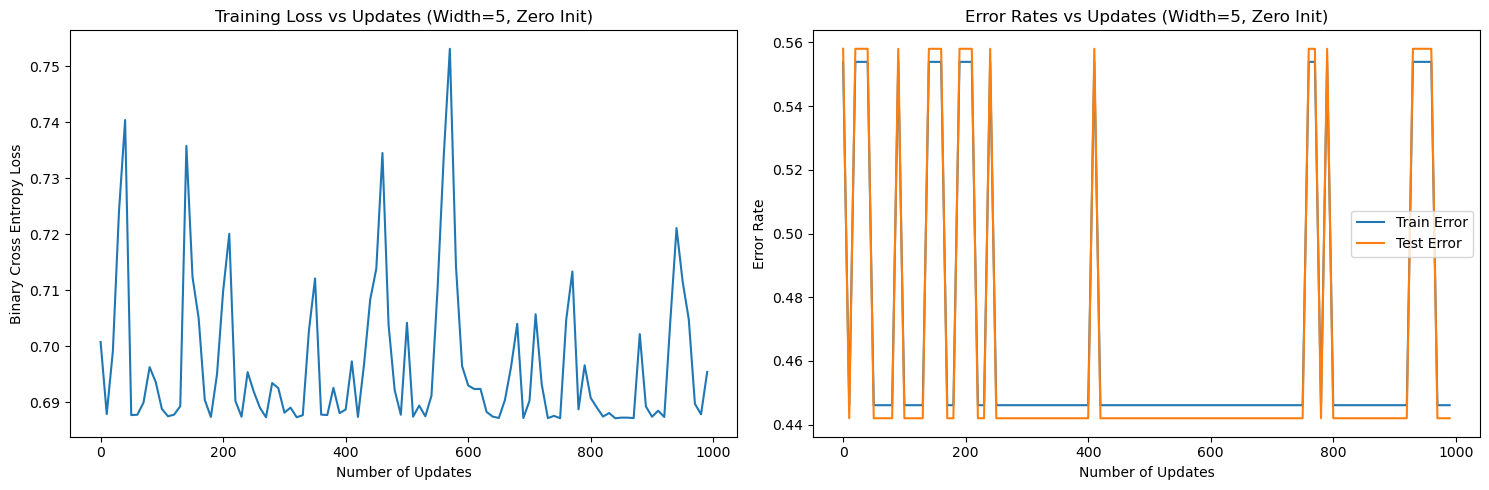


Final Results for Width 5 with Zero Initialization:
Final Training Error: 0.4461
Final Test Error: 0.4420


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid(x):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """Derivative of sigmoid function"""
    return sigmoid(x) * (1 - sigmoid(x))

def initialize_weights(input_size, hidden_sizes, output_size):
    """Initialize weights and biases with zeros"""
    weights = []
    biases = []
    
    # Input to first hidden layer
    weights.append(np.zeros((hidden_sizes[0], input_size)))
    biases.append(np.zeros((hidden_sizes[0], 1)))
    
    # Between hidden layers
    for i in range(1, len(hidden_sizes)):
        weights.append(np.zeros((hidden_sizes[i], hidden_sizes[i-1])))
        biases.append(np.zeros((hidden_sizes[i], 1)))
    
    # Last hidden to output layer
    weights.append(np.zeros((output_size, hidden_sizes[-1])))
    biases.append(np.zeros((output_size, 1)))
    
    return weights, biases

def forward_propagation(X, weights, biases):
    """Forward pass through the network"""
    activations = [X]
    zs = []
    
    for W, b in zip(weights, biases):
        z = np.dot(W, activations[-1]) + b
        a = sigmoid(z)
        zs.append(z)
        activations.append(a)
    
    return activations, zs

def backward_propagation(X, y, weights, biases, activations, zs):
    """Compute gradients using backpropagation"""
    gradients_w = [np.zeros_like(W) for W in weights]
    gradients_b = [np.zeros_like(b) for b in biases]
    
    # Output layer error
    delta = activations[-1] - y.reshape(-1, 1)
    
    # Gradient for last layer
    gradients_w[-1] = np.dot(delta, activations[-2].T)
    gradients_b[-1] = delta
    
    # Backpropagate through hidden layers
    for l in range(len(weights) - 2, -1, -1):
        delta = np.dot(weights[l + 1].T, delta) * sigmoid_derivative(zs[l])
        gradients_w[l] = np.dot(delta, activations[l].T)
        gradients_b[l] = delta
    
    return gradients_w, gradients_b

def load_data(train_path, test_path):
    """Load and prepare the bank-note dataset"""
    train_data = pd.read_csv(train_path, header=None)
    test_data = pd.read_csv(test_path, header=None)
    
    X_train = train_data.iloc[:, :-1].values.T
    y_train = train_data.iloc[:, -1].values
    X_test = test_data.iloc[:, :-1].values.T
    y_test = test_data.iloc[:, -1].values
    
    return X_train, y_train, X_test, y_test

def shuffle_data(X, y):
    """Shuffle the data while keeping features and labels aligned"""
    indices = np.random.permutation(X.shape[1])
    return X[:, indices], y[indices]

def learning_rate_schedule(gamma0, d, t):
    """Implement the learning rate schedule: γt = γ0/(1 + (γ0/d)t)"""
    return gamma0 / (1 + (gamma0/d) * t)

def compute_loss(X, y, weights, biases):
    """Compute binary cross entropy loss"""
    activations, _ = forward_propagation(X, weights, biases)
    predictions = activations[-1]
    epsilon = 1e-15  # prevent log(0)
    return -np.mean(y * np.log(predictions + epsilon) + 
                   (1 - y) * np.log(1 - predictions + epsilon))

def compute_accuracy(X, y, weights, biases):
    """Compute classification accuracy"""
    activations, _ = forward_propagation(X, weights, biases)
    predictions = (activations[-1] > 0.5).reshape(-1)
    return np.mean(predictions == y)

def train_network(X_train, y_train, X_test, y_test, hidden_width, gamma0, d, max_updates=1000):
    """Train neural network using SGD with specified learning rate schedule"""
    input_size = X_train.shape[0]
    hidden_sizes = [hidden_width, hidden_width]  # equal width layers
    output_size = 1
    
    weights, biases = initialize_weights(input_size, hidden_sizes, output_size)
    
    train_losses = []
    train_errors = []
    test_errors = []
    updates = 0
    
    X_shuffled, y_shuffled = shuffle_data(X_train, y_train)
    i = 0
    
    while updates < max_updates:
        # Reshuffle if we've used all examples
        if i >= X_train.shape[1]:
            X_shuffled, y_shuffled = shuffle_data(X_train, y_train)
            i = 0
            
        # Get current learning rate
        lr = learning_rate_schedule(gamma0, d, updates)
        
        # Get single training example
        X = X_shuffled[:, [i]]
        y = y_shuffled[[i]]
        
        # Forward and backward passes
        activations, zs = forward_propagation(X, weights, biases)
        gradients_w, gradients_b = backward_propagation(
            X, y, weights, biases, activations, zs)
        
        # Update weights and biases
        for j in range(len(weights)):
            weights[j] -= lr * gradients_w[j]
            biases[j] -= lr * gradients_b[j]
        
        # Track metrics (every 10 updates to reduce computation)
        if updates % 10 == 0:
            train_loss = compute_loss(X_train, y_train, weights, biases)
            train_acc = compute_accuracy(X_train, y_train, weights, biases)
            test_acc = compute_accuracy(X_test, y_test, weights, biases)
            
            train_losses.append(train_loss)
            train_errors.append(1 - train_acc)
            test_errors.append(1 - test_acc)
            
            print(f"Updates: {updates}, Loss: {train_loss:.4f}, "
                  f"Train Error: {1-train_acc:.4f}, Test Error: {1-test_acc:.4f}")
        
        updates += 1
        i += 1
    
    return train_losses, train_errors, test_errors, weights, biases

def main():
    # Load data
    train_path = "train.csv"
    test_path = "test.csv"
    X_train, y_train, X_test, y_test = load_data(train_path, test_path)
    
    np.random.seed(2)
    
    # Test with a single width since behavior will be similar for all widths
    width = 5
    print(f"\nTraining network with width {width} and zero initialization")
    
    train_losses, train_errors, test_errors, weights, biases = train_network(
        X_train, y_train, X_test, y_test,
        hidden_width=width,
        gamma0=0.1,
        d=100,
        max_updates=1000
    )
    
    # Plot learning curves
    plt.figure(figsize=(15, 5))
    
    # Plot loss vs updates
    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(train_losses)*10, 10), train_losses)
    plt.title(f'Training Loss vs Updates (Width={width}, Zero Init)')
    plt.xlabel('Number of Updates')
    plt.ylabel('Binary Cross Entropy Loss')
    
    # Plot error rates vs updates
    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(train_errors)*10, 10), train_errors, label='Train Error')
    plt.plot(range(0, len(test_errors)*10, 10), test_errors, label='Test Error')
    plt.title(f'Error Rates vs Updates (Width={width}, Zero Init)')
    plt.xlabel('Number of Updates')
    plt.ylabel('Error Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Results for Width {width} with Zero Initialization:")
    print(f"Final Training Error: {train_errors[-1]:.4f}")
    print(f"Final Test Error: {test_errors[-1]:.4f}")

if __name__ == "__main__":
    main()